In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
from __future__ import print_function
import numpy as np
import pandas as pd 
import cv2 as cv
import os
import h5py
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import scipy.misc
import scipy.ndimage

from tqdm import tqdm
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
# from scipy.misc import imresize
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Convolution2D, Conv2DTranspose, Concatenate, BatchNormalization, Layer
# from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dropout, Flatten, Lambda
from keras.optimizers import SGD, Adam, Nadam
from keras.utils import np_utils, plot_model
from keras.callbacks import TensorBoard
from keras import layers
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras import backend as K

np.random.seed(1337)  # for reproducibility

In [3]:
def load_file_names(path):
    list_of_file_names = os.listdir(path)
    list_of_file_names.sort() #sorts in place
    return list_of_file_names

In [4]:
m = 72
n = 88
sketch_dim = (m,n)
img_dim = (m,n,3)
num_images = 3600
num_epochs = 50
batch_size = 5
global gt_names, sketch_names
gt_names = []
sketch_names = []
IMAGE_PATH = '/content/drive/MyDrive/dataset sample/CUHK_train_photo'
SKETCH_PATH = '/content/drive/MyDrive/dataset sample/CUHK_train_sketch'

gt_names = load_file_names(IMAGE_PATH)
sketch_names = load_file_names(SKETCH_PATH)
del gt_names[0]
del sketch_names[0]

In [5]:
print(gt_names)
print(sketch_names)

['f1-001-01.jpg', 'f1-003-01.jpg', 'f1-007-01.jpg', 'f1-008-01.jpg', 'f1-009-01.jpg', 'f1-010-01.jpg', 'f1-011-01.jpg', 'f1-012-01.jpg', 'f1-013-01.jpg', 'f1-014-01.jpg', 'f1-015-01.jpg']
['f1-001-01-sz1.jpg', 'f1-003-01-sz1.jpg', 'f1-007-01-sz1.jpg', 'f1-008-01-sz1.jpg', 'f1-009-01-sz1.jpg', 'f1-010-01-sz1.jpg', 'f1-011-01-sz1.jpg', 'f1-012-01-sz1.jpg', 'f1-013-01-sz1.jpg', 'f1-014-01-sz1.jpg', 'f1-015-01-sz1.jpg']


In [6]:
def get_features(Y):
    Z = deepcopy(Y)
    Z = preprocess_vgg(Z)
    features = vgg.predict(Z, batch_size = 5, verbose = 0)
    return features

In [7]:
def sub_plot(x,y,z):
    fig = plt.figure()
    a = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(x, cmap='gray')
    a.set_title('Sketch')
    plt.axis("off")
    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(z)
    a.set_title('Prediction')
    plt.axis("off")
    a = fig.add_subplot(1,3,3)
    imgplot = plt.imshow(y)
    a.set_title('Ground Truth')
    plt.axis("off")
    plt.show()

In [8]:
def imshow(x, gray=False):
    plt.imshow(x, cmap='gray' if gray else None)
    plt.show()

In [9]:
def get_batch(idx, X = True, Y = True, W = True):
    batch_size = 11
    X_train = np.zeros((batch_size, m, n), dtype='float32')
    Y_train = np.zeros((batch_size, m, n, 3), dtype='float32')
    F_train = None
    x_path = SKETCH_PATH
    y_path = IMAGE_PATH
    
    if X:
        # Load Sketches
        for i in range(batch_size):
            file = os.path.join(x_path, sketch_names[i])
            img = cv.imread(file, 0)
            img = resize(img, sketch_dim)
            img = img.astype('float32')
            X_train[i] = img / 255.
            
    if Y:
        # Load Ground-truth Images
        for i in range(batch_size):
            file = os.path.join(y_path, gt_names[i])
            img = cv.imread(file)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = resize(img, img_dim)
            img = img.astype('float32')
            Y_train[i] = img
    if W:
        F_train = get_features(Y_train)
    
    X_train = np.reshape(X_train, (batch_size, m, n, 1))
    return X_train, Y_train, F_train

In [27]:
def calculate_psnr(img1, img2):
    # Load the images
    # img1 = cv2.imread(img1)
    # img2 = cv2.imread(img2)

    # Calculate the MSE (Mean Squared Error) for each channel
    mse_r = np.mean((img1[:,:,0] - img2[:,:,0]) ** 2)
    mse_g = np.mean((img1[:,:,1] - img2[:,:,1]) ** 2)
    mse_b = np.mean((img1[:,:,2] - img2[:,:,2]) ** 2)

    # Calculate the PSNR (Peak Signal-to-Noise Ratio) for each channel
    max_pixel_value = 255.0  # Assumes 8-bit images
    psnr_r = 10 * np.log10(max_pixel_value / mse_r)
    psnr_g = 10 * np.log10(max_pixel_value / mse_g)
    psnr_b = 10 * np.log10(max_pixel_value / mse_b)

    # Calculate the average PSNR across all channels
    psnr_avg = (psnr_r + psnr_g + psnr_b) / 3.0
    return psnr_avg

In [28]:
def calculate_ssim(img1, img2):
    # # Load the images
    # img1 = io.imread(img1_path, as_gray=True)
    # img2 = io.imread(img2_path, as_gray=True)
    # Calculate the SSIM
   # print(type(img1))
    ssim_l=[]
    ssim_l.append(ssim(img1[:,:,0], img2[:,:,0],data_range=img1.max() - img1.min()))
    ssim_l.append(ssim(img1[:,:,1], img2[:,:,1],data_range=img1.max() - img1.min()))
    ssim_l.append(ssim(img1[:,:,2], img2[:,:,2],data_range=img1.max() - img1.min()))
    return np.mean(ssim_l)

In [10]:
X, T, _ = get_batch(1, Y = True, W = False)

In [11]:
def preprocess_vgg(x, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}
    x = 255. * x
    if data_format == 'channels_first':
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
        # Zero-center by mean pixel
        x[:, 0, :, :] = x[:, 0, :, :] - 103.939
        x[:, 1, :, :] = x[:, 1, :, :] - 116.779
        x[:, 2, :, :] = x[:, 2, :, :] - 123.68
    else:
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
        # Zero-center by mean pixel
        x[:, :, :, 0] = x[:, :, :, 0] - 103.939
        x[:, :, :, 1] = x[:, :, :, 1] - 116.779
        x[:, :, :, 2] = x[:, :, :, 2] - 123.68
    return x

In [12]:
def feature_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def pixel_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred))) + 0.00001 * total_variation_loss(y_pred)

def adv_loss(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=-1)

def total_variation_loss(y_pred):
    if K.image_data_format() == 'channels_first':
        a = K.square(y_pred[:, :, :m - 1, :n - 1] - y_pred[:, :, 1:, :n - 1])
        b = K.square(y_pred[:, :, :m - 1, :n - 1] - y_pred[:, :, :m - 1, 1:])
    else:
        a = K.square(y_pred[:, :m - 1, :n - 1, :] - y_pred[:, 1:, :n - 1, :])
        b = K.square(y_pred[:, :m - 1, :n - 1, :] - y_pred[:, :m - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [13]:
norm_vec = K.constant([103.939, 116.779, 123.68])

def preprocess_VGG(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_data_format()
    assert dim_ordering in {'channels_last', 'channels_first'}
    # x has pixels intensities between 0 and 1
    x = 255. * x
    if dim_ordering == 'channels_first':
        norm_vec_tensor = K.reshape(norm_vec, (1,3,1,1))
        x = x - norm_vec_tensor
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        norm_vec_tensor = K.reshape(norm_vec, (1,1,1,3))
        x = x - norm_vec_tensor
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x

In [14]:
def generator_model(input_img):

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.add([x, res])

    # Decoder
    res = Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv1')(encoded)
    x = layers.add([encoded, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(128, (2, 2), activation='relu', padding='same', name='block6_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block7_conv1')(x)
    res = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(64, (2, 2), activation='relu', padding='same', name='block8_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block9_conv1')(x)
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(32, (2, 2), activation='relu', padding='same', name='block10_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block11_conv1')(x)
    res = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return decoded

In [15]:
def generator_model_2(input_img):
    x = Convolution2D(32, (9, 9), padding="same", strides=(1,1))(input_img)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(64, (3, 3), padding="same", strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(128, (3, 3), padding="same", strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    # then 5 res blocks
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = Concatenate([x, r], mode='sum', concat_axis=1)
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = Concatenate([x, r], mode='sum', concat_axis=1)
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = Concatenate([x, r], mode='sum', concat_axis=1)
              
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = Concatenate([x, r], mode='sum', concat_axis=1)
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = Concatenate([x, r], mode='sum', concat_axis=1)
    
    # the 2 deconv blocks
    x = Conv2DTranspose(64, (3, 3), output_shape=(batch_size, m/2, n/2, 64), padding='same', strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Conv2DTranspose(32, (3, 3), output_shape=(batch_size, m/2, n/2, 32), padding='same', strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # final conv block
    x = Convolution2D(3, (9, 9), padding="same", strides=(1,1))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("sigmoid")(x)
    
    return x

In [16]:
def discriminator_model(img_input):
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='d_block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='d_block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='d_block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='d_block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block5_pool')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='d_fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='relu', name='d_fc2')(x)
    model = Model(img_input, x)
    
    return model

In [17]:
def feat_model(img_input):
    # extract vgg feature
    vgg_16 = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None)
    # freeze VGG_16 when training
    for layer in vgg_16.layers:
        layer.trainable = False
    
    vgg_first2 = Model(vgg_16.input, vgg_16.get_layer('block2_conv2').output)
    Norm_layer = Lambda(preprocess_VGG)
    x_VGG = Norm_layer(img_input)
    feat = vgg_first2(img_input)
    return feat

In [18]:
def full_model(summary = True):
    input_img = Input(shape=(m, n, 1))
    generator = generator_model(input_img)
    feat = feat_model(generator)
    model = Model(input_img, [generator, feat], name='architect')
    model.summary()
    return model

In [19]:
def get_gen_model():
    gen_model = full_model()
    model = Model(gen_model.input, gen_model.get_layer('block2_conv1').output)
    return model

In [70]:
def train_full_model():
    generator = generator_model(True)
    discriminator = discriminator_model()

    full_model = Sequential()
    full_model.add(generator)
    full_model.add(discriminator)

    def loss(y_true, y_pred):
        return 1 - discriminator.predict(y_pred)

    generator.compile(loss=loss, optimizer='adam')
    full_model.compile(loss='binary_crossentropy', optimizer='adam')
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    #128
    for epoch in num_epochs:
        num_batches = num_images // batch_size

        for batch in num_batches:
            X,Y = get_batch(batch)

            Y_pred = generator.predict(X) 
            discriminator_Y = [0] * batch_size + [1] * batch_size
            discriminator_X = np.concatenate(Y_pred, Y)
            discriminator.trainable=True
            discr_loss = discriminator.fit_on_batch(discriminator_X, discriminator_Y)

            discriminator.trainable=False

            generator_loss = generator.fit_on_batch(X, Y)

        generator.save_weights(generator,True)
        discriminator.save_weights(discriminator, True)

In [20]:
def compute_vgg():
    base_model = vgg16.VGG16(weights='imagenet', include_top=False)
    model = Model(base_model.input, base_model.get_layer('block2_conv2').output)
    num_batches = num_images // batch_size
    for batch in range(num_batches):
        _, Y = get_batch(batch, X = False);
        Y = preprocess_vgg(Y)
        features = model.predict(Y, verbose = 1)
        f = h5py.File('features/feat_%d' % batch, "w")
        dset = f.create_dataset("features", data=features)

In [22]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False)
vgg = Model(base_model.input, base_model.get_layer('block2_conv2').output)

58889256/58889256 [==============================] - 2s 0us/step


In [23]:
m = 72
n = 88
sketch_dim = (m,n)
img_dim = (m, n, 3)
num_images = 11
batch_size = 1
model = full_model()
optim = Adam(lr=1e-4,beta_1=0.9, beta_2=0.999, epsilon=1e-8)
#optim = SGD(lr=1e-4, decay=1e-3, momentum=0.7, nesterov=True)
#optim = Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss=[pixel_loss, feature_loss], loss_weights=[1, 0.01], optimizer=optim)
model.load_weights('/content/drive/MyDrive/weights_faces')
for epoch in range(num_epochs):
    num_batches = num_images // batch_size

    for batch in range(num_batches):
        X,Y,W = get_batch(batch)
        #loss = model.fit(X, X, verbose = True, shuffle="batch", epochs = 1, batch_size=sub_batch_size)
        #loss = model.train_on_batch([X], [Y,W])
        loss = model.train_on_batch(X, [Y, W])
        print("Loss in Epoch # ",epoch,"| Batch #", batch, ":", loss)

    # model.save_weights("weights_4_%d" % epoch)

Model: "architect"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 72, 88, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 72, 88, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 72, 88, 32)   4128        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 36, 44, 32)   0           ['conv2d_1[0][0]']               
                                                                                          

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Loss in Epoch #  0 | Batch # 0 : [6.629577159881592, 0.38638293743133545, 624.3193969726562]
Loss in Epoch #  0 | Batch # 1 : [6.602243423461914, 0.3604939877986908, 624.1749267578125]
Loss in Epoch #  0 | Batch # 2 : [6.59473991394043, 0.35295549035072327, 624.1784057617188]
Loss in Epoch #  0 | Batch # 3 : [6.567947864532471, 0.3259409964084625, 624.20068359375]
Loss in Epoch #  0 | Batch # 4 : [6.54335355758667, 0.3009999096393585, 624.2353515625]
Loss in Epoch #  0 | Batch # 5 : [6.533371448516846, 0.29080629348754883, 624.256591796875]
Loss in Epoch #  0 | Batch # 6 : [6.532231330871582, 0.2896884083747864, 624.2542724609375]
Loss in Epoch #  0 | Batch # 7 : [6.529758930206299, 0.2873564660549164, 624.240234375]
Loss in Epoch #  0 | Batch # 8 : [6.520002365112305, 0.27783912420272827, 624.21630859375]
Loss in Epoch #  0 | Batch # 9 : [6.507206916809082, 0.26533636450767517, 624.1870727539062]
Loss in Epoch #  0 | Batch # 10 : [6.497880935668945, 0.25640520453453064, 624.1475830078

In [24]:
X, T, _ = get_batch(1, Y = True, W = False)
Y, W = model.predict(X)

1/1 [==============================] - 0s 359ms/step


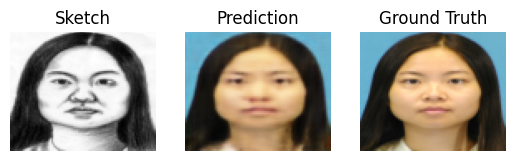

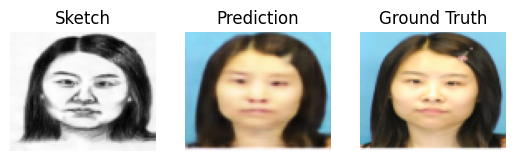

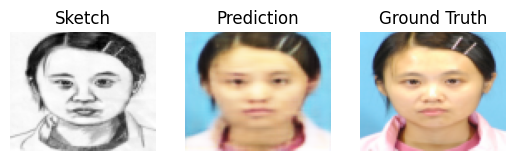

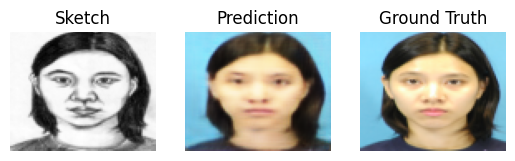

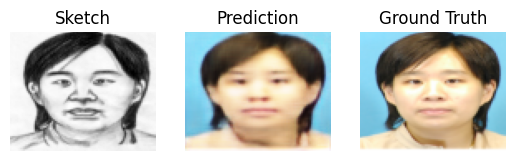

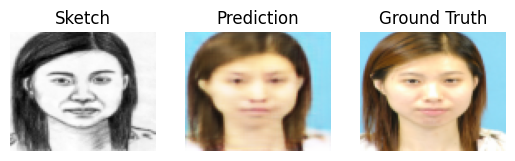

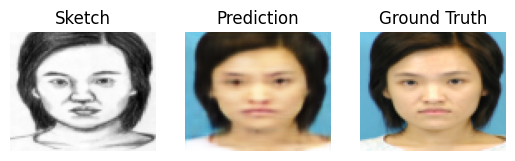

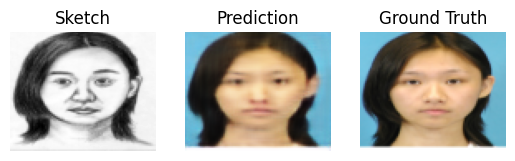

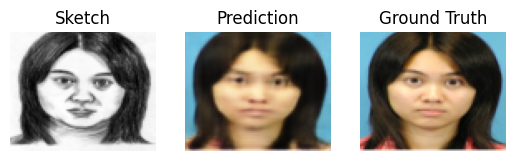

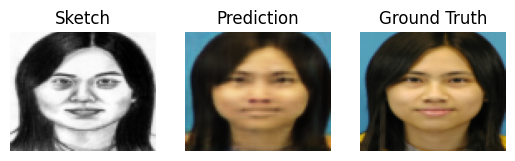

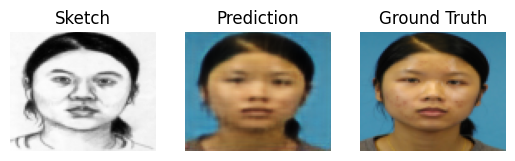

In [26]:
for i in range(num_images):
  x = X[i].reshape(m,n)
  y = Y[i]
  sub_plot(x, T[i], y)

In [30]:
ssim_list = []
psnr_list = []
for i in range(num_images):
  p = Y[i]
  q = T[i]
  ssim_list.append(calculate_ssim(p, q))
  psnr_list.append(calculate_psnr(p, q))

In [31]:
print('Average ssim of all the test images is', np.mean(ssim_list))
print('Average psnr of all the test images is', np.mean(psnr_list))

Average ssim of all the test images is 0.9036602558601654
Average psnr of all the test images is 53.58046812806303
